# AutoAugment using DALI conditionals - advanced example

In this example, we will demonstrate, that DALI conditionals can be used in more complex scenarios. As the [AutoGraph](https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/index.md) that powers DALI conditionals can trace through function calls and makes the distinction between regular Python control flow and `if` statements with DALI DataNodes inside conditions, we can utilize that to build more generic pipelines. 

We will proceed in the following order:
* explain what is AutoAugment
* prepare simple AutoAugment operations using DALI operators
* build an AutoAugment policy using list of such operations
* prepare a naive implementation of the DALI pipeline
* prepare the optimal variant of the DALI pipeline.

## AutoAugment

AutoAugment defines image augmentation policies: each policy consist of set of subpolicies. Subpolicy, which consists of two operations, is randomly selected and applied to an image. Operation within the subpolicy can be one of: shear, translation, rotation or some color transformations like adjusting brightness, contrast or others.

Within the subpolicy  each operation has two parameters:
* a probability of applying that operation for the given input
* magnitude - which allows for parametrization of the operation.

You can read more about AutoAugment [here](https://arxiv.org/abs/1805.09501). 

We will use DALI conditionals both to select the policy and to realize the conditional application of operation within the subpolicy.

## Defining operations for subpolicies
DALI operators are fairly flexible. We will first define some simplified wrappers implementing a subset of AutoAugment operations.

We will expose them as a function taking two arguments - the input images and the magnitude - this will allow us to use them with unified interface.

Magnitudes in AutoAugment are constrained to 10 discrete values, taken from a range specific to each operation. 

We start with a decorator, which helps us defining such functions - the resulting function will accept the discrete magnitude value and map it internally to the specific range of values.

In [1]:
from nvidia.dali.pipeline import experimental 
from nvidia.dali.types import DALIDataType
from nvidia.dali import fn
from nvidia.dali import tensors

In [2]:
from functools import wraps
import numpy as np

def op_magnitude_range(mag_lo, mag_hi, steps=10):
    """Convert the function from taking a generic parameter to taking magnitude in [0, steps) range."""
    def decorator(function):
        @wraps(function)
        def wrapper(imgs, magnitude):
            param_range = np.linspace(mag_lo, mag_hi, steps)
            parameter = param_range[magnitude]
            return function(imgs, parameter)  
        return wrapper
    return decorator

Now we can define some AutoAugment operations taken from the AutoAugment paper by the means of DALI operators.
Note the `@op_magnitude_range` decorator - thanks to it, all functions accept the magnitude values between 0 and 9 as a parameter and map it to the range specified in the decorator.  

In [3]:
@op_magnitude_range(-0.3, 0.3)
def shearX(img, parameter):
    mt = fn.transforms.shear(shear=[parameter, 0])
    return fn.warp_affine(img, matrix=mt, fill_value=0, inverse_map=False)

@op_magnitude_range(-0.3, 0.3)
def shearY(img, parameter):
    mt = fn.transforms.shear(shear=[0, parameter])
    return fn.warp_affine(img, matrix=mt, fill_value=0, inverse_map=False)

@op_magnitude_range(-150, 150)
def translateX(img, parameter):
    mt = fn.transforms.translation(offset=[parameter, 0])
    return fn.warp_affine(img, matrix=mt, fill_value=0, inverse_map=False)

@op_magnitude_range(-150, 150)
def translateY(img, parameter):
    mt = fn.transforms.translation(offset=[0, parameter])
    return fn.warp_affine(img, matrix=mt, fill_value=0, inverse_map=False)

@op_magnitude_range(-30, 30)
def rotate(img, parameter):
    return fn.rotate(img, angle=parameter, fill_value=0)

@op_magnitude_range(-0.1, 1.9)
def brightness(img, parameter):
    return fn.brightness(img, brightness=parameter)

@op_magnitude_range(-0.1, 1.9)
def contrast(img, parameter):
    return fn.contrast(img, contrast=parameter)

## Defining subpolicies
The next step would be to define the list of subpolicies. We will assume similar argument order as the tables used in the appendix A of the AutoAugment paper. The `subpolicy` function will take the callable `op0` (and `op1`) - one of operations that we defined a moment ago, next the `p0` (and `p1`) - the probability of applying that operations and next its magnitude.

It will return a callable that takes the input `images` and two batches of random numbers that we use for testing the probability and running the operations conditionally.
Note here: `rand0` is expected to be a DataNode representing a random value (or a batch of random values). The conditions in those `if` statements are DataNodes, so those `if` statemnts would be traced as DALI conditionals. 

In [4]:
def subpolicy(op0, p0, mag0, op1, p1, mag1):
    def subpolicy_impl(images, rand0, rand1):
        if rand0 < p0:
            images = op0(images, mag0)
        if rand1 < p1:
            images = op1(images, mag1)
        return images
    return subpolicy_impl

## Policy
Now, we can easily create a policy - a list of subpolicies with a probability and magnitude for each opeartion.
Note, that the subpolicies here are just an example and are not taken from the AutoAugment paper directly.

In [5]:
policies = [
    subpolicy(rotate,     0.7, 2, translateX, 0.3 ,9),
    subpolicy(contrast,   0.3, 3, rotate,     0.8, 4),
    subpolicy(shearX,     0.7, 2, contrast,   0.3, 7),
    subpolicy(translateY, 0.7, 2, shearX,     0.3, 6),
    subpolicy(brightness, 0.5, 7, translateY, 0.8, 3),
    subpolicy(rotate,     0.7, 2, rotate,     0.7, 3),
    subpolicy(translateY, 0.8, 8, contrast,   0.8, 2),
    subpolicy(shearY,     0.1, 3, shearX,     0.6 ,9),
]

## AutoAugment sequential pipeline - naive solution

The next step is to build a pipeline, that will generate a random `policy_id` for every sample, check it against all possible policy numbers (currently, we defined 8), and call that policy within appropriate `if` scope.
One way to do it, would be to write a sequence of `if` instruactions manually, like this:

In [6]:
@experimental.pipeline_def(enable_conditionals=True, batch_size=8, num_threads=4, device_id=0, seed=42)
def auto_augment_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    
    policy_id = fn.random.uniform(values=list(range(len(policies))), dtype=DALIDataType.INT32)
    
    rand0 = fn.random.uniform()
    rand1 = fn.random.uniform()
    
    if policy_id == 0:
        images = policies[0](images, rand0, rand1)
    elif policy_id == 1:
        images = policies[1](images, rand0, rand1)
    else:
        ...
    resized = fn.resize(images, resize_x=400, resize_y=400)
    return resized, policy_id

This is quite a laborious approach. We can utilize the fact, that only if statements that have DataNode within condition contribute to the pipeline definition - the rest of the code is executed normally during tracing. We can write a finite loop that would spell out all the `if` statements for us. We can add a `print` instruction to observe the effects of tracining when we crate the pipeline.

In [7]:
@experimental.pipeline_def(enable_conditionals=True, batch_size=8, num_threads=4, device_id=0, seed=13)
def auto_augment_seq_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    
    policy_id = fn.random.uniform(values=list(range(len(policies))), dtype=DALIDataType.INT32)
    
    rand0 = fn.random.uniform()
    rand1 = fn.random.uniform()
    
    for i in range(len(policies)):
        if policy_id == i:
            print(f"Tracing `if policy_id == {i}`")
            images = policies[i](images, rand0, rand1)
    resized = fn.resize(images, resize_x=400, resize_y=400)
    return resized, policy_id

In [8]:
aug_seq_pipe = auto_augment_seq_pipe()
aug_seq_pipe.build()

Tracing `if policy_id == 0`
Tracing `if policy_id == 1`
Tracing `if policy_id == 2`
Tracing `if policy_id == 3`
Tracing `if policy_id == 4`
Tracing `if policy_id == 5`
Tracing `if policy_id == 6`
Tracing `if policy_id == 7`


In [9]:
import matplotlib.pyplot as plt

def display(output):
    data_idx = 0
    fig, axes = plt.subplots(len(output) // 2, 2, figsize=(15, 15))
    if len(output) == 1:
        axes = [axes]
    for i, out in enumerate(output):
        img = out if isinstance(out, tensors.TensorCPU) else out.as_cpu()
        axes[i // 2, i % 2].imshow(img);
        axes[i // 2, i % 2].axis('off') 

TensorListCPU(
    [6 2 4 7 0 6 2 1],
    dtype=DALIDataType.INT32,
    num_samples=8,
    shape=[(), (), (), (), (), (), (), ()])


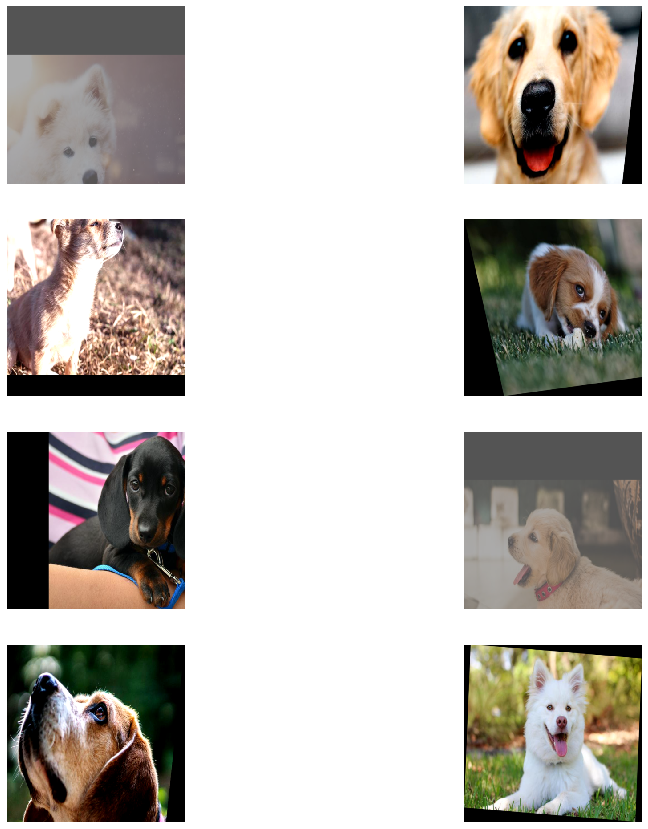

In [10]:
output, policy_id = aug_seq_pipe.run()
display(output)
print(policy_id)

We created a chain of split and merge operations - for each policy the whole batch is processed, every image sample, as well as the random parameters that we used would go through `len(policies)` pairs of split and merge operators. This may lead to some overhead. As an alternative, we can build a tree of `if` statements resulting in `log(len(policies))` split and merge operations for every processed sample. 

## AutoAugment binary tree pipeline - optimal solution

First, let's demonstrate the underlying idea. We have `len(policies)` and we need apply a sequence of `if` statements, so where we selected on of the policies. We will do it in tree-like fashion, splitting the processed range in half, on half would be processed by the `if` branch, the other by the `else` branch - we will apply recursion in those branches. When we get to the range of size 1, we selected one policy and our batch consist only of images that were assigned to it.

First, let's see how our recursion would work:

In [11]:
def recursive_split_show(start_offset, elems, level=0):
    indent = '  ' * level
    if elems == 1:
        print(f"{indent} # Selected augmentation policy {start_offset}")
        return
    half_size = elems // 2
    print(f"{indent}if policy_id < {start_offset + half_size}:  # processing [{start_offset}, {start_offset + half_size}) ")
    recursive_split_show(start_offset, half_size, level + 1)
    print(f"{indent}else:  # processing [{start_offset + half_size}, {start_offset + elems}) ")
    recursive_split_show(start_offset + half_size, elems - half_size, level + 1)

recursive_split_show(0, 8)

if policy_id < 4:  # processing [0, 4) 
  if policy_id < 2:  # processing [0, 2) 
    if policy_id < 1:  # processing [0, 1) 
       # Selected augmentation policy 0
    else:  # processing [1, 2) 
       # Selected augmentation policy 1
  else:  # processing [2, 4) 
    if policy_id < 3:  # processing [2, 3) 
       # Selected augmentation policy 2
    else:  # processing [3, 4) 
       # Selected augmentation policy 3
else:  # processing [4, 8) 
  if policy_id < 6:  # processing [4, 6) 
    if policy_id < 5:  # processing [4, 5) 
       # Selected augmentation policy 4
    else:  # processing [5, 6) 
       # Selected augmentation policy 5
  else:  # processing [6, 8) 
    if policy_id < 7:  # processing [6, 7) 
       # Selected augmentation policy 6
    else:  # processing [7, 8) 
       # Selected augmentation policy 7


We can see in our visualization, that we have 3 levels of nesting - each sample will be routed through 3 split and merge operations.

Now we can define the pipeline utilizing the techinque we presented above. Note, that we keep the random variables `rand0` and `rand1` above the conditional statements in the global scope. This will ensure that the batches are produced once and when we access them within the `if` condition scope, they will be split accordingly to the nesting of the `if` statements.

In [12]:
def apply_policies(imgs, policy_id, policies):
    """To each sample in `imgs` apply the corresponding `policies[policy_id]` """
    
    rand0 = fn.random.uniform()
    rand1 = fn.random.uniform()
    
    def recursive_split(imgs, rand0, rand1, policy_id, start_offset, elems):
        if elems == 1:
            policy = policies[start_offset]
            return policy(imgs, rand0, rand1)
        half_size = elems // 2
        if policy_id < start_offset + half_size: 
            return recursive_split(imgs, rand0, rand1, policy_id, start_offset, half_size)
        else:
            return recursive_split(imgs, rand0, rand1, policy_id, start_offset + half_size, elems - half_size)
    
    return recursive_split(imgs, rand0, rand1, policy_id, 0, len(policies))

    
@experimental.pipeline_def(enable_conditionals=True, batch_size=8, num_threads=4, device_id=0, seed=7)
def auto_augment_pipe():
    jpegs, _ = fn.readers.file(device="cpu", file_root="../data/images")
    images = fn.decoders.image(jpegs, device="mixed")
    policy_id = fn.random.uniform(values=list(range(len(policies))), dtype=DALIDataType.INT32)
    
    result = apply_policies(images, policy_id, policies)
    
    resized = fn.resize(result, resize_x=400, resize_y=400)
    return resized, policy_id

In [13]:
aug_pipe = auto_augment_pipe()
aug_pipe.build()

TensorListCPU(
    [1 4 2 5 1 6 5 6],
    dtype=DALIDataType.INT32,
    num_samples=8,
    shape=[(), (), (), (), (), (), (), ()])


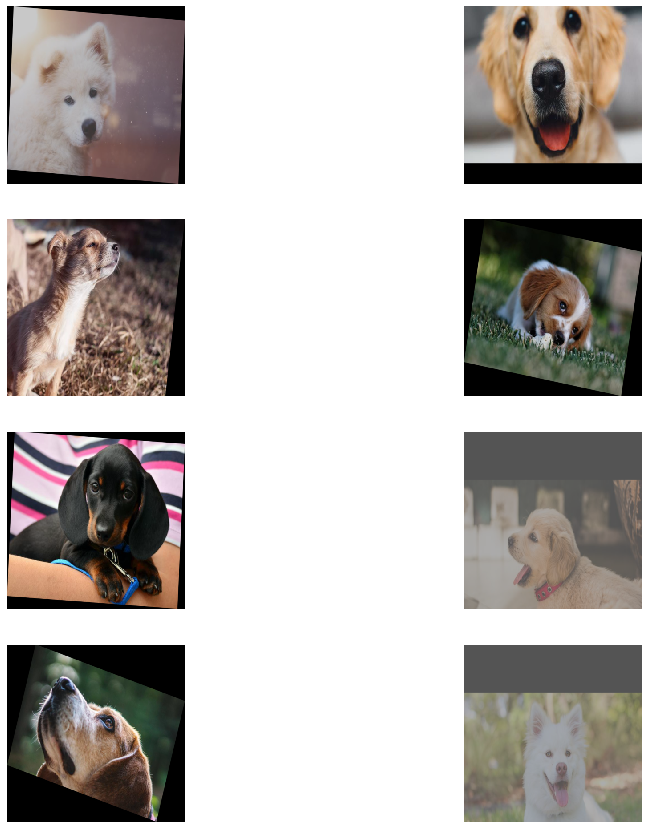

In [14]:
output, policy_id = aug_pipe.run()
display(output)
print(policy_id)